## Setup

We'll use the Optimism public RPC to query transaction data. For more comprehensive data, you can use an Alchemy or Infura API key.

In [40]:
import os
from datetime import datetime
from dotenv import load_dotenv
import pandas as pd
import requests
from web3 import Web3

# Load environment variables
load_dotenv()

# Configuration
ATTACKER_ADDRESS = "0x8B6B008A0073D34D04ff00210E7200Ab00003300"
CONTRACT_ADDRESS = "0x80f95d330417a4acEfEA415FE9eE28db7A0A1Cdb"
MY_ADDRESS = "0x073f26f0c3fc100e7b075c3dc3cde0a777497d20"

# Optimism RPC - use Alchemy if available, otherwise public RPC
ALCHEMY_API_KEY = os.getenv("ALCHEMY_API_KEY", "")
if ALCHEMY_API_KEY:
    OPTIMISM_RPC = f"https://opt-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"
else:
    OPTIMISM_RPC = "https://mainnet.optimism.io"

# Optimistic Etherscan API (optional, for more detailed tx history)
ETHERSCAN_API_KEY = os.getenv("ETHERSCAN_API_KEY", "")

print(ETHERSCAN_API_KEY)
print(f"🎯 Target Contract: {CONTRACT_ADDRESS}")
print(f"🔴 Attacker Wallet: {ATTACKER_ADDRESS}")
print(f"🌐 RPC: {'Alchemy' if ALCHEMY_API_KEY else 'Public Optimism RPC'}")
print(f"📊 Etherscan API: {'Available' if ETHERSCAN_API_KEY else 'Not configured'}")

52JSW14NRHTUQ8JVRM9GFNIB3T59X5JKRQ
🎯 Target Contract: 0x80f95d330417a4acEfEA415FE9eE28db7A0A1Cdb
🔴 Attacker Wallet: 0x8B6B008A0073D34D04ff00210E7200Ab00003300
🌐 RPC: Alchemy
📊 Etherscan API: Available


## Connect to Optimism

In [31]:
# Connect to Optimism
w3 = Web3(Web3.HTTPProvider(OPTIMISM_RPC))

if w3.is_connected():
    print(f"✅ Connected to Optimism")
    print(f"📦 Latest block: {w3.eth.block_number}")
    print(f"⛓️  Chain ID: {w3.eth.chain_id}")
else:
    print("❌ Failed to connect to Optimism")

✅ Connected to Optimism
📦 Latest block: 144409619
⛓️  Chain ID: 10


## GenImNFT Contract ABI (relevant functions)

We only need the function signatures for the exploit analysis.

In [50]:
# Minimal ABI for the functions we're analyzing
GENIMG_ABI = [
    {
        "name": "requestImageUpdate",
        "type": "function",
        "inputs": [
            {"name": "tokenId", "type": "uint256"},
            {"name": "newImageUrl", "type": "string"}
        ],
        "outputs": []
    },
    {
        "name": "mintPrice",
        "type": "function",
        "inputs": [],
        "outputs": [{"name": "", "type": "uint256"}]
    },
    {
        "name": "ImageUpdateRequested",
        "type": "event",
        "inputs": [
            {"name": "tokenId", "type": "uint256", "indexed": True},
            {"name": "requester", "type": "address", "indexed": True},
            {"name": "newImageUrl", "type": "string", "indexed": False}
        ]
    },
    {
        "name": "Transfer",
        "type": "event",
        "inputs": [
            {"name": "from", "type": "address", "indexed": True},
            {"name": "to", "type": "address", "indexed": True},
            {"name": "tokenId", "type": "uint256", "indexed": True}
        ]
    }
]

# Create contract instance
contract = w3.eth.contract(
    address=Web3.to_checksum_address(CONTRACT_ADDRESS),
    abi=GENIMG_ABI
)

# Get function signature for requestImageUpdate
REQUEST_IMAGE_UPDATE_SIG = w3.keccak(text="requestImageUpdate(uint256,string)")[:4].hex()
print(f"📝 requestImageUpdate signature: 0x{REQUEST_IMAGE_UPDATE_SIG}")

📝 requestImageUpdate signature: 0x9f42ba30


In [51]:
def get_all_transactions(address: str, max_count: int = 100) -> pd.DataFrame:
    """
    Fetch all transactions FROM an address using Alchemy API.
    
    Args:
        address: The wallet address to query
        max_count: Maximum number of transactions to fetch (default 100)
    
    Returns:
        DataFrame with transaction details
    """
    if not ALCHEMY_API_KEY:
        print("❌ No ALCHEMY_API_KEY set in .env")
        return pd.DataFrame()
    
    url = f"https://opt-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"
    
    # Get all transactions FROM the address
    payload = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "alchemy_getAssetTransfers",
        "params": [{
            "fromAddress": address,
            "category": ["external", "erc20", "erc721"],
            "withMetadata": True,
            "order": "desc",
            "maxCount": hex(max_count)
        }]
    }
    
    print(f"🔍 Fetching transactions from: {address}")
    response = requests.post(url, json=payload)
    
    if response.status_code != 200:
        print(f"❌ HTTP Error: {response.status_code}")
        return pd.DataFrame()
    
    data = response.json()
    
    if "error" in data:
        print(f"❌ Alchemy Error: {data['error']}")
        return pd.DataFrame()
    
    transfers = data.get("result", {}).get("transfers", [])
    print(f"✅ Found {len(transfers)} transactions")
    
    if not transfers:
        return pd.DataFrame()
    
    # Convert to DataFrame
    rows = []
    for tx in transfers:
        rows.append({
            "hash": tx.get("hash"),
            "blockNum": int(tx.get("blockNum"), 16),
            "timestamp": tx.get("metadata", {}).get("blockTimestamp"),
            "from": tx.get("from"),
            "to": tx.get("to"),
            "value": float(tx.get("value", 0) or 0),
            "asset": tx.get("asset"),
            "category": tx.get("category")
        })
    
    df = pd.DataFrame(rows)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    return df

# Test with your address
my_txs = get_all_transactions(MY_ADDRESS, max_count=20)

if not my_txs.empty:
    print(f"\n📋 Your recent transactions:")
    display(my_txs)

🔍 Fetching transactions from: 0x073f26f0c3fc100e7b075c3dc3cde0a777497d20
✅ Found 20 transactions

📋 Your recent transactions:
✅ Found 20 transactions

📋 Your recent transactions:


,hash,blockNum,timestamp,from,to,value,asset,category
0,0xfa82a11b961f957c95ddece0ab0a627e26f991641888...,144358019,2025-11-28 07:26:55+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x0000000000000000000000000000000000000000,0.00000,None,erc721
1,0x058061f36ac0876540661449b05ff5f9bb2214631d24...,144357999,2025-11-28 07:26:15+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
2,0x3b2762e72904212a7608904eb50cdcf57379f283322e...,144357966,2025-11-28 07:25:09+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
3,0x572b64b69a924182733ac4efd607c2ac7e988a6841e3...,144357536,2025-11-28 07:10:49+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
4,0x7fd95df3a080b89aed334178887381cf4aaaf1429d43...,144270851,2025-11-26 07:01:19+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
5,0xe71115e8972da6ffe38d1fdb1bdb57db30eccf4bc218...,144270317,2025-11-26 06:43:31+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
6,0x4a94eb1095f1543d0efbf5a7208e4b3f40ca8d9cc028...,144209862,2025-11-24 21:08:21+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
7,0xe0e1900f768f2166237d6686606e6aad04c1591d1a99...,144209545,2025-11-24 20:57:47+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
8,0x62bbcb77fcaa06a979020792882b3e17e97005c71205...,144209536,2025-11-24 20:57:29+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
9,0xa0aa9b6d57dd410af7e6ab08ab5353150ff26e2829e4...,144209519,2025-11-24 20:56:55+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external


In [62]:
# Better approach: Query the ImageUpdateRequested events from the contract
# Using PUBLIC Optimism RPC which allows larger block ranges than Alchemy Free Tier

print("🔍 Querying ImageUpdateRequested events from contract...")
print("=" * 60)

# Use public Optimism RPC for getLogs (allows larger ranges)
public_w3 = Web3(Web3.HTTPProvider("https://mainnet.optimism.io"))

# Get ImageUpdateRequested events
event_sig = public_w3.keccak(text="ImageUpdateRequested(uint256,address,string)")
print(f"Event topic: 0x{event_sig.hex()}")

# Query using public RPC with larger chunks
latest_block = public_w3.eth.block_number
chunk_size = 2000  # Public RPC allows larger ranges
total_blocks_to_scan = 500000  # ~20 days on Optimism

all_events = []

print(f"\n📦 Scanning {total_blocks_to_scan} blocks in chunks of {chunk_size}...")
print(f"   From block: {latest_block - total_blocks_to_scan}")
print(f"   To block: {latest_block}")
print()

total_chunks = total_blocks_to_scan // chunk_size
processed = 0

for start in range(latest_block - total_blocks_to_scan, latest_block, chunk_size):
    end = min(start + chunk_size - 1, latest_block)
    processed += 1
    
    try:
        logs = public_w3.eth.get_logs({
            "address": Web3.to_checksum_address(CONTRACT_ADDRESS),
            "topics": [event_sig],
            "fromBlock": start,
            "toBlock": end
        })
        
        if logs:
            all_events.extend(logs)
            print(f"   ✅ Block {start}-{end}: Found {len(logs)} events")
            
    except Exception as e:
        error_msg = str(e)
        if "block range" in error_msg.lower():
            print(f"   ⚠️  Block range too large, trying smaller chunks...")
            # Try smaller chunks if range too large
            for sub_start in range(start, end, 500):
                sub_end = min(sub_start + 499, end)
                try:
                    sub_logs = public_w3.eth.get_logs({
                        "address": Web3.to_checksum_address(CONTRACT_ADDRESS),
                        "topics": [event_sig],
                        "fromBlock": sub_start,
                        "toBlock": sub_end
                    })
                    if sub_logs:
                        all_events.extend(sub_logs)
                        print(f"      ✅ Block {sub_start}-{sub_end}: Found {len(sub_logs)} events")
                except Exception as sub_e:
                    print(f"      ❌ Block {sub_start}-{sub_end}: {sub_e}")
        else:
            print(f"   ❌ Block {start}-{end}: {e}")
    
    # Progress update every 50 chunks
    if processed % 50 == 0:
        print(f"   📊 Progress: {processed}/{total_chunks} chunks ({100*processed/total_chunks:.1f}%), Events so far: {len(all_events)}")

print(f"\n✅ Total events found: {len(all_events)}")

if all_events:
    events_data = []
    for log in all_events:
        token_id = int(log["topics"][1].hex(), 16)
        requester = "0x" + log["topics"][2].hex()[-40:]
        
        events_data.append({
            "blockNumber": log["blockNumber"],
            "transactionHash": log["transactionHash"].hex(),
            "tokenId": token_id,
            "requester": requester.lower(),
            "is_attacker": requester.lower() == ATTACKER_ADDRESS.lower()
        })
    
    events_df = pd.DataFrame(events_data)
    
    # Show attacker's events
    attacker_events = events_df[events_df["is_attacker"]]
    print(f"\n🔴 Events from ATTACKER: {len(attacker_events)}")
    if not attacker_events.empty:
        display(attacker_events.head(20))
        
        # Calculate stolen amount
        num_attacks = len(attacker_events)
        stolen_eth = num_attacks * mint_price_eth
        print(f"\n💸 Estimated stolen: {num_attacks} × {mint_price_eth} ETH = {stolen_eth:.6f} ETH")
    
    # Show other requesters
    other_events = events_df[~events_df["is_attacker"]]
    print(f"\n✅ Events from OTHER users: {len(other_events)}")
    
    # Summary by requester
    print(f"\n📊 Summary by requester:")
    requester_summary = events_df.groupby("requester").agg({
        "transactionHash": "count",
        "is_attacker": "first"
    }).rename(columns={"transactionHash": "event_count"})
    requester_summary = requester_summary.sort_values("event_count", ascending=False)
    display(requester_summary)
else:
    print("No ImageUpdateRequested events found in the scanned block range.")
    print("\n💡 The contract may be new or have no requestImageUpdate calls yet.")

🔍 Querying ImageUpdateRequested events from contract...
Event topic: 0x9c5aec7f143040caecc06c378c9f67b2539c1516233c0769598c2a7db4316cee

📦 Scanning 500000 blocks in chunks of 2000...
   From block: 143921722
   To block: 144421722


📦 Scanning 500000 blocks in chunks of 2000...
   From block: 143921722
   To block: 144421722

   📊 Progress: 50/250 chunks (20.0%), Events so far: 0
   📊 Progress: 50/250 chunks (20.0%), Events so far: 0
   📊 Progress: 100/250 chunks (40.0%), Events so far: 0
   📊 Progress: 100/250 chunks (40.0%), Events so far: 0
   ✅ Block 144205722-144207721: Found 1 events
   ✅ Block 144205722-144207721: Found 1 events
   ✅ Block 144207722-144209721: Found 12 events
   ✅ Block 144207722-144209721: Found 12 events
   ✅ Block 144209722-144211721: Found 1 events
   ✅ Block 144209722-144211721: Found 1 events
   📊 Progress: 150/250 chunks (60.0%), Events so far: 14
   📊 Progress: 150/250 chunks (60.0%), Events so far: 14
   ✅ Block 144269722-144271721: Found 2 events
   ✅ 

,blockNumber,transactionHash,tokenId,requester,is_attacker
0,144207649,4165d84f1fac193b5e2ef8ed019a0ba0bcef2c0f19d8b7...,142,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
1,144207727,d3edb67c036ac2ce7e0ec7009c16250226593dd720f39a...,143,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
2,144207761,d1a106a7744f77fd567f5b21d4999204960ecc9637749b...,144,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
3,144207995,5414ced57b001455c314b911268ec0b82b5b3958684d22...,145,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
4,144208124,7512fbd1e6ad70de8d836929e757fe7e944db6483c0bc2...,146,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
5,144208191,6d5245c934d43576611990d83c1da018143b9871514282...,147,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
6,144208455,3293aa258560b1a1fd43ea64a2b66302b82a109767a2f7...,148,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
7,144208645,5f02f1b3410933817f47c67f687eb7a840e2c6306b7bdf...,149,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
8,144208788,f650d4f488d14913dd94a7a21650339d2d7ee598ea4d77...,150,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
9,144209405,fcf02e62ca4604e495587fc86ff11643102556ecfde495...,151,0x8b6b008a0073d34d04ff00210e7200ab00003300,True



💸 Estimated stolen: 16 × 2e-05 ETH = 0.000320 ETH

✅ Events from OTHER users: 1

📊 Summary by requester:


,event_count,is_attacker
requester,,
0x8b6b008a0073d34d04ff00210e7200ab00003300,16,True
0xaaebc1441323b8ad6bdf6793a8428166b510239c,1,False


In [63]:
# Analyze the attack events we found
print("🔴 Attack Analysis from Events")
print("=" * 60)

if 'events_df' in dir() and not events_df.empty:
    # Get attacker events
    attacker_events_df = events_df[events_df["is_attacker"]].copy()
    
    if not attacker_events_df.empty:
        print(f"\n📊 Attacker Statistics:")
        print(f"   Total attacks: {len(attacker_events_df)}")
        print(f"   Unique tokens targeted: {attacker_events_df['tokenId'].nunique()}")
        print(f"   Block range: {attacker_events_df['blockNumber'].min()} - {attacker_events_df['blockNumber'].max()}")
        
        # Calculate stolen ETH
        stolen_eth = len(attacker_events_df) * mint_price_eth
        print(f"\n💸 Estimated Stolen Funds:")
        print(f"   Attacks: {len(attacker_events_df)}")
        print(f"   ETH per attack: {mint_price_eth} ETH")
        print(f"   Total stolen: {stolen_eth:.6f} ETH")
        
        # Get timestamps for each attack by fetching block info
        print(f"\n⏱️  Fetching timestamps for attack transactions...")
        
        timestamps = []
        for _, row in attacker_events_df.iterrows():
            try:
                block = public_w3.eth.get_block(row["blockNumber"])
                timestamps.append(datetime.fromtimestamp(block["timestamp"]))
            except:
                timestamps.append(None)
        
        attacker_events_df["timestamp"] = timestamps
        
        print(f"\n📋 All {len(attacker_events_df)} Attack Transactions:")
        display(attacker_events_df)
        
        # Timeline
        if attacker_events_df["timestamp"].notna().any():
            print(f"\n⏰ Attack Timeline:")
            print(f"   First attack: {attacker_events_df['timestamp'].min()}")
            print(f"   Last attack: {attacker_events_df['timestamp'].max()}")
            
            # Attacks per day
            attacker_events_df["date"] = attacker_events_df["timestamp"].dt.date
            attacks_per_day = attacker_events_df.groupby("date").size()
            print(f"\n📅 Attacks per day:")
            for date, count in attacks_per_day.items():
                print(f"   {date}: {count} attacks")
        
        # Most targeted tokens
        print(f"\n🎯 Most targeted tokens:")
        token_counts = attacker_events_df["tokenId"].value_counts().head(10)
        for token_id, count in token_counts.items():
            print(f"   Token #{token_id}: {count} attacks")
        
        # Save attack data
        attack_df = attacker_events_df  # For compatibility with later cells
        
    else:
        print("No attacks from the identified attacker found.")
        
    # Show legitimate users
    other_events_df = events_df[~events_df["is_attacker"]]
    if not other_events_df.empty:
        print(f"\n✅ Legitimate Users ({len(other_events_df)} events):")
        for requester in other_events_df["requester"].unique():
            count = len(other_events_df[other_events_df["requester"] == requester])
            print(f"   {requester[:20]}...: {count} requests")
else:
    print("❌ No events_df available. Run the event query cell first.")

🔴 Attack Analysis from Events

📊 Attacker Statistics:
   Total attacks: 16
   Unique tokens targeted: 16
   Block range: 144207649 - 144270852

💸 Estimated Stolen Funds:
   Attacks: 16
   ETH per attack: 2e-05 ETH
   Total stolen: 0.000320 ETH

⏱️  Fetching timestamps for attack transactions...

📋 All 16 Attack Transactions:


,blockNumber,transactionHash,tokenId,requester,is_attacker,timestamp
0,144207649,4165d84f1fac193b5e2ef8ed019a0ba0bcef2c0f19d8b7...,142,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 20:54:35
1,144207727,d3edb67c036ac2ce7e0ec7009c16250226593dd720f39a...,143,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 20:57:11
2,144207761,d1a106a7744f77fd567f5b21d4999204960ecc9637749b...,144,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 20:58:19
3,144207995,5414ced57b001455c314b911268ec0b82b5b3958684d22...,145,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:06:07
4,144208124,7512fbd1e6ad70de8d836929e757fe7e944db6483c0bc2...,146,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:10:25
5,144208191,6d5245c934d43576611990d83c1da018143b9871514282...,147,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:12:39
6,144208455,3293aa258560b1a1fd43ea64a2b66302b82a109767a2f7...,148,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:21:27
7,144208645,5f02f1b3410933817f47c67f687eb7a840e2c6306b7bdf...,149,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:27:47
8,144208788,f650d4f488d14913dd94a7a21650339d2d7ee598ea4d77...,150,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:32:33
9,144209405,fcf02e62ca4604e495587fc86ff11643102556ecfde495...,151,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:53:07



⏰ Attack Timeline:
   First attack: 2025-11-24 20:54:35
   Last attack: 2025-11-26 08:01:21

📅 Attacks per day:
   2025-11-24: 14 attacks
   2025-11-26: 2 attacks

🎯 Most targeted tokens:
   Token #142: 1 attacks
   Token #143: 1 attacks
   Token #144: 1 attacks
   Token #145: 1 attacks
   Token #146: 1 attacks
   Token #147: 1 attacks
   Token #148: 1 attacks
   Token #149: 1 attacks
   Token #150: 1 attacks
   Token #151: 1 attacks

✅ Legitimate Users (1 events):
   0xaaebc1441323b8ad6b...: 1 requests


## Attacker Wallet Analysis

Analyze the attacker's wallet for additional context.

In [64]:
# Get attacker wallet info
attacker_checksum = Web3.to_checksum_address(ATTACKER_ADDRESS)

balance = w3.eth.get_balance(attacker_checksum)
balance_eth = balance / 1e18

tx_count = w3.eth.get_transaction_count(attacker_checksum)

print(f"🔴 Attacker Wallet Analysis")
print(f"=" * 50)
print(f"Address: {ATTACKER_ADDRESS}")
print(f"Current Balance: {balance_eth:.6f} ETH")
print(f"Total Transactions: {tx_count}")
print(f"")
print(f"🔗 View on Optimistic Etherscan:")
print(f"   https://optimistic.etherscan.io/address/{ATTACKER_ADDRESS}")

🔴 Attacker Wallet Analysis
Address: 0x8B6B008A0073D34D04ff00210E7200Ab00003300
Current Balance: 0.001616 ETH
Total Transactions: 364

🔗 View on Optimistic Etherscan:
   https://optimistic.etherscan.io/address/0x8B6B008A0073D34D04ff00210E7200Ab00003300


# Fund tracing

In [ ]:
# Fund Tracing: Where did the attacker move the funds?
print("💰 Fund Tracing Analysis")
print("=" * 60)

# Known addresses for CEX/Bridges on Optimism
KNOWN_ADDRESSES = {
    "0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40": "Binance",
    "0x4200000000000000000000000000000000000010": "Optimism L1 Bridge",
    "0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45": "Uniswap V3 Router",
    "0x1111111254eeb25477b68fb85ed929f73a960582": "1inch Router",
}

def get_transactions_to_address(address: str, max_count: int = 100) -> pd.DataFrame:
    """Fetch transactions TO an address"""
    if not ALCHEMY_API_KEY:
        return pd.DataFrame()
    url = f"https://opt-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"
    payload = {"jsonrpc": "2.0", "id": 1, "method": "alchemy_getAssetTransfers",
               "params": [{"toAddress": address, "category": ["external", "erc20", "erc721"],
                          "withMetadata": True, "order": "desc", "maxCount": hex(max_count)}]}
    response = requests.post(url, json=payload)
    data = response.json()
    if "error" in data or not data.get("result", {}).get("transfers"):
        return pd.DataFrame()
    rows = [{"hash": tx["hash"], "timestamp": pd.to_datetime(tx["metadata"]["blockTimestamp"]),
             "from": tx["from"], "to": tx["to"], "value": float(tx.get("value", 0) or 0),
             "asset": tx.get("asset")} for tx in data["result"]["transfers"]]
    return pd.DataFrame(rows)

# Get outgoing transactions
outgoing_txs = get_all_transactions(ATTACKER_ADDRESS, max_count=500)

if not outgoing_txs.empty:
    print(f"\n✅ {len(outgoing_txs)} outgoing transactions")
    
    # Summarize by destination
    summary = []
    for to_addr in outgoing_txs["to"].unique():
        subset = outgoing_txs[outgoing_txs["to"] == to_addr]
        known = KNOWN_ADDRESSES.get(to_addr.lower()) if to_addr else None
        is_self = to_addr and to_addr.lower() == ATTACKER_ADDRESS.lower()
        summary.append({
            "address": to_addr[:20] + "..." if to_addr else "None",
            "known_as": known or ("Self" if is_self else "Unknown"),
            "tx_count": len(subset),
            "total_value": subset["value"].sum(),
            "assets": list(subset["asset"].unique())
        })
    
    dest_df = pd.DataFrame(summary).sort_values("total_value", ascending=False)
    display(dest_df.head(10))
    
    # Key findings
    self_txs = dest_df[dest_df["known_as"] == "Self"]
    unknown_txs = dest_df[dest_df["known_as"] == "Unknown"]
    
    print(f"\n📊 Summary:")
    print(f"   Self-transfers: {len(self_txs)} destinations, {self_txs['tx_count'].sum()} txs")
    print(f"   Unknown destinations: {len(unknown_txs)} addresses")
    
    if not unknown_txs.empty:
        print(f"\n❓ Unknown destinations (potential accomplices):")
        for _, row in unknown_txs.head(5).iterrows():
            print(f"   {row['address']} | {row['total_value']:.4f} | {row['assets']}")

💰 Fund Tracing Analysis

📤 Fetching all outgoing transactions from attacker...
🔍 Fetching transactions from: 0x8B6B008A0073D34D04ff00210E7200Ab00003300
✅ Found 358 transactions
✅ Found 358 transactions

✅ Found 358 outgoing transactions

🎯 Destination Analysis:
------------------------------------------------------------

✅ Found 358 outgoing transactions

🎯 Destination Analysis:
------------------------------------------------------------


,address,known_as,tx_count,total_value,assets
2,0xda60f6f99cea7fb4acfb3dfcb817691eaa41ba4e,Unknown,2,3.985313e+01,"[USDC, sUSD]"
1,0xda60192af08b0564fd0f0aab19072a9d4149ba4e,Unknown,1,1.983040e+01,[UЅDC.e]
0,0x8b6b008a0073d34d04ff00210e7200ab00003300,Self,355,2.356854e-10,[ETH]



📊 Destination Categories:
------------------------------------------------------------

🔁 Self-Transfers (1 addresses):
   Total: 0.000000 ETH

❓ Unknown Addresses (2 addresses):
   0xda60f6f99cea7fb4ac...: 39.853135 (2 txs)
      Assets: USDC, sUSD
   0xda60192af08b0564fd...: 19.830403 (1 txs)
      Assets: UЅDC.e

📋 SUMMARY
Total outgoing value: 59.683538
To CEX: 0.000000
To Bridges: 0.000000
To DEX: 0.000000
To Mixers: 0.000000
Self-transfers: 0.000000
To Unknown: 59.683538


In [ ]:
# Funding Sources: Where did the attacker get funds from?
print("💵 Funding Source Analysis")
print("=" * 60)

incoming_txs = get_transactions_to_address(ATTACKER_ADDRESS, max_count=100)

if not incoming_txs.empty:
    print(f"\n✅ {len(incoming_txs)} incoming transactions")
    
    # Summarize by source
    summary = []
    for from_addr in incoming_txs["from"].unique():
        subset = incoming_txs[incoming_txs["from"] == from_addr]
        known = KNOWN_ADDRESSES.get(from_addr.lower()) if from_addr else None
        summary.append({
            "address": from_addr[:20] + "..." if from_addr else "None",
            "known_as": known or "Unknown",
            "tx_count": len(subset),
            "total_value": subset["value"].sum(),
            "assets": list(subset["asset"].unique()),
            "first_tx": subset["timestamp"].min()
        })
    
    source_df = pd.DataFrame(summary).sort_values("total_value", ascending=False)
    display(source_df)
    
    # Key findings
    cex_funding = source_df[source_df["known_as"].str.contains("Binance|Bybit|OKX", na=False, case=False)]
    if not cex_funding.empty:
        print(f"\n🏦 CEX Funding (TRACEABLE):")
        for _, row in cex_funding.iterrows():
            print(f"   {row['known_as']}: {row['total_value']:.6f} ETH")
else:
    print("❌ No incoming transactions found (may be funded via internal txs)")

💵 Funding Source Analysis

✅ Found 921 incoming transactions

📥 Funding Sources:
------------------------------------------------------------

✅ Found 921 incoming transactions

📥 Funding Sources:
------------------------------------------------------------


,address,known_as,tx_count,total_value,assets,first_tx,last_tx
19,0xd152f549545093347a162dce210e7293f1452150,Unknown,1,1.000000e+03,[WLFI],2025-11-03 07:56:21+00:00,2025-11-03 07:56:21+00:00
22,0x6adaa3eba85c77e8566b73aefb4c2f39df4046ca,Unknown,2,4.000000e+01,[GRAI],2025-11-02 02:42:31+00:00,2025-11-02 02:42:31+00:00
25,0x93fc04cd6d108588ecd844c7d60f46635037b5a3,Unknown,2,3.985313e+01,"[sUSD, USDC]",2025-10-30 03:48:05+00:00,2025-10-30 03:48:05+00:00
1,0xec16bd5874a10e5c171810fea8d7f6c9236a55b2,Unknown,39,3.393174e+01,[VELO],2025-10-25 10:18:27+00:00,2025-11-29 07:30:41+00:00
24,0x3327c272562f8a1a530c4419b8b33b3f3537b5a3,Unknown,1,1.983040e+01,[UЅDC.e],2025-10-30 03:52:35+00:00,2025-10-30 03:52:35+00:00
16,0xe21328bd90de1433f99512608558ff9481d94be2,Unknown,3,8.174889e+00,[USDC],2025-11-05 06:18:13+00:00,2025-11-06 06:06:05+00:00
18,0xc6249f4e0df56474165eb2d95d53941f54d94be2,Unknown,1,4.503572e+00,[UЅDС],2025-11-05 07:18:41+00:00,2025-11-05 07:18:41+00:00
7,0x1d68fc7c741a9e7ea1ffa447ef5230d917fc244f,Unknown,1,1.283224e+00,[WCT],2025-11-20 01:55:35+00:00,2025-11-20 01:55:35+00:00
12,0x7e3cb178e9857b53b1c41e34d5997c6e3774cf2c,Unknown,1,6.027034e-01,[VELO],2025-11-09 22:58:49+00:00,2025-11-09 22:58:49+00:00
2,0x8c864d0c8e476bf9eb9d620c10e1296fb0e2f940,Unknown,429,1.310063e-01,"[WETH, WBTC, USDC, USDT, OP, WLD]",2025-10-23 00:35:57+00:00,2025-11-28 23:41:49+00:00



🔍 Key Findings:
------------------------------------------------------------

❓ Unknown Funding Sources (investigate further):
   0xd152f549545093347a162dce210e7293f1452150
   Value: 1000.000000 ETH, Txs: 1
   First: 2025-11-03 07:56:21+00:00, Last: 2025-11-03 07:56:21+00:00
   0x6adaa3eba85c77e8566b73aefb4c2f39df4046ca
   Value: 40.000000 ETH, Txs: 2
   First: 2025-11-02 02:42:31+00:00, Last: 2025-11-02 02:42:31+00:00
   0x93fc04cd6d108588ecd844c7d60f46635037b5a3
   Value: 39.853135 ETH, Txs: 2
   First: 2025-10-30 03:48:05+00:00, Last: 2025-10-30 03:48:05+00:00
   0xec16bd5874a10e5c171810fea8d7f6c9236a55b2
   Value: 33.931741 ETH, Txs: 39
   First: 2025-10-25 10:18:27+00:00, Last: 2025-11-29 07:30:41+00:00
   0x3327c272562f8a1a530c4419b8b33b3f3537b5a3
   Value: 19.830403 ETH, Txs: 1
   First: 2025-10-30 03:52:35+00:00, Last: 2025-10-30 03:52:35+00:00
   0xe21328bd90de1433f99512608558ff9481d94be2
   Value: 8.174889 ETH, Txs: 3
   First: 2025-11-05 06:18:13+00:00, Last: 2025-11-06 06:

In [ ]:
# Verify if the attacker address is a Smart Contract
print("🔍 Is the Attacker Address a Smart Contract?")
print("=" * 70)

DELEGATE_ADDRESS = "0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820"
attacker_checksum = Web3.to_checksum_address(ATTACKER_ADDRESS)

# Get code at address
code = w3.eth.get_code(attacker_checksum)

if len(code) > 0:
    print(f"\n✅ YES! The address has bytecode ({len(code)} bytes)")
    print(f"   First 50 bytes: {code[:50].hex()}")
    
    # Check for ERC-7702 pattern (ef0100 prefix + delegate address)
    if code[:2].hex() == "ef01":
        delegate_addr = "0x" + code[3:23].hex()
        print(f"\n🚨 ERC-7702 DELEGATED EOA DETECTED!")
        print(f"   → This is an EOA that delegated code execution to:")
        print(f"   → {delegate_addr}")
        print(f"\n   Meaning: The REAL attacker owns the private key to {ATTACKER_ADDRESS[:15]}...")
    else:
        print(f"\n   This is a regular Smart Contract")
else:
    print(f"\n❌ No bytecode - this is a regular EOA")

# Check the delegate/bot implementation
print(f"\n" + "-" * 70)
print(f"🔍 Bot Implementation: {DELEGATE_ADDRESS}")

delegate_code = w3.eth.get_code(Web3.to_checksum_address(DELEGATE_ADDRESS))
print(f"   Bytecode Length: {len(delegate_code)} bytes")
print(f"   → This is the MEV bot code that gets executed")

🔍 Ist die Attacker-Adresse ein Smart Contract?

✅ JA! Die Adresse ist ein SMART CONTRACT!
   Bytecode Länge: 23 bytes
   Bytecode (first 100 bytes): ef01003ecc9f049c569e59a2de5b3a51bc7b8a94225820

🤖 Interpretation:
   - Dies ist ein Smart Contract Wallet (SCW)
   - Wahrscheinlich ein ERC-4337 Account oder ähnlich
   - Der OWNER des Contracts ist der echte Angreifer
   - Die 'Self-Transfers' sind execute() Aufrufe an diesen Contract

----------------------------------------------------------------------
🔍 Ist die Delegate-Adresse ein Smart Contract?

✅ JA! Delegate ist auch ein Smart Contract!
   Bytecode Länge: 1118 bytes

🔑 Versuche den Owner des Attacker-Contracts zu finden...
----------------------------------------------------------------------
   owner(): 0x8B6B008A0073D34D04ff00210E7200Ab00003300
   admin(): 0x0000000000000000000000000000000000000001
   getOwner(): 0x8B6B008A0073D34D04ff00210E7200Ab00003300
   implementation(): 0x0000000000000000000000000000000000000001

🔍 Prüfe 

## 📋 Zusammenfassung der Forensik-Analyse

### Wichtigste Entdeckung: ERC-7702 Delegation

Die Angreifer-Adresse `0x8B6B...3300` ist ein **ERC-7702 Delegated EOA**:

```
Bytecode: ef0100 + 3ecc9f049c569e59a2de5b3a51bc7b8a94225820
         ^^^^^^   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
         Prefix   Bot Implementation Address
```

→ Der **echte Angreifer** besitzt den Private Key zu dieser Adresse und ist **unbekannt**.

### Angriffs-Statistik

| Metrik | Wert |
|--------|------|
| Angriffe | 16 (Token #142-#157) |
| Zeitraum | 24.-26. Nov 2025 |
| Gestohlener Betrag | ~0.00032 ETH |

### Netzwerk-Struktur

```
UNKNOWN OWNER → 0x8B6B...3300 (ERC-7702 EOA)
                      ↓ delegates to
                0x3ecC...5820 (MEV Bot Code)
                      ↓ attacks
                GenImNFT Contract
                      ↓ sends funds to
                0xda60f6... & 0xda60192... (Vanity addresses)
```

### Offene Fragen
1. Wer hat den Bot-Contract deployed?
2. Wer steht hinter den 0xda60... Vanity-Adressen?
3. Cross-chain Aktivität auf anderen L2s?

### Links
- [Attacker](https://optimistic.etherscan.io/address/0x8B6B008A0073D34D04ff00210E7200Ab00003300)
- [Bot Implementation](https://optimistic.etherscan.io/address/0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820)

In [ ]:
# Cross-Chain Analyse: Prüfe die Adressen auf Ethereum Mainnet
print("🌐 Cross-Chain Analyse: Ethereum Mainnet")
print("=" * 70)

# Key addresses from the analysis
BOT_IMPLEMENTATION = "0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820"
RECIPIENT_1 = "0xda60f6f99cea7fb4acfb3dfcb817691eaa41ba4e"
RECIPIENT_2 = "0xda60192af08b0564fd0f0aab19072a9d4149ba4e"

# Etherscan v2 API - supports all chains with chainid parameter
ETHERSCAN_V2_URL = "https://api.etherscan.io/v2/api"
ADDRESSES_TO_CHECK = [
    ("Attacker", ATTACKER_ADDRESS),
    ("Bot Implementation", BOT_IMPLEMENTATION),
    ("Recipient 1", RECIPIENT_1),
    ("Recipient 2", RECIPIENT_2),
]

def check_address_mainnet(address: str, name: str) -> dict:
    """Check address on Ethereum Mainnet via Etherscan v2 API"""
    result = {"name": name, "address": address, "has_activity": False, "tx_count": 0, "balance_eth": 0}
    if not ETHERSCAN_API_KEY:
        return result
    
    # Get balance and transaction list
    for action, key in [("balance", "balance_eth"), ("txlist", "txs")]:
        params = {"chainid": 1, "module": "account", "action": action, 
                  "address": address, "apikey": ETHERSCAN_API_KEY}
        if action == "txlist":
            params.update({"startblock": 0, "endblock": 99999999, "page": 1, "offset": 20, "sort": "asc"})
        try:
            response = requests.get(ETHERSCAN_V2_URL, params=params)
            data = response.json()
            if data.get("status") == "1" and data.get("result"):
                if action == "balance":
                    result["balance_eth"] = int(data["result"]) / 1e18
                else:
                    result["txs"] = data["result"]
                    result["tx_count"] = len(data["result"])
                    result["has_activity"] = len(data["result"]) > 0
        except: pass
    return result

# Check all addresses on Mainnet
print("\n📍 Adressen auf Ethereum Mainnet prüfen:")
mainnet_results = []
for name, addr in ADDRESSES_TO_CHECK:
    result = check_address_mainnet(addr, name)
    mainnet_results.append(result)
    
    if result["has_activity"]:
        print(f"\n   ✅ {name}: {addr[:20]}...")
        print(f"      TX Count: {result['tx_count']}, Balance: {result['balance_eth']:.6f} ETH")
        if result.get("txs"):
            first = result["txs"][0]
            print(f"      First TX: {datetime.fromtimestamp(int(first['timeStamp']))}")
            print(f"      From: {first['from'][:20]}...")
            # Check for deployed contracts
            for tx in result["txs"]:
                if tx.get("to") == "" and tx.get("contractAddress"):
                    print(f"      🏭 Deployed: {tx['contractAddress']}")
    else:
        print(f"\n   ❌ {name}: Keine Aktivität auf Mainnet")

# Summary
print("\n" + "=" * 70)
print("📋 CROSS-CHAIN ZUSAMMENFASSUNG")
print("=" * 70)
active = [r for r in mainnet_results if r["has_activity"]]
print(f"\n   {len(active)}/{len(mainnet_results)} Adressen sind auf Ethereum Mainnet aktiv")

🌐 Cross-Chain Analyse: Ethereum Mainnet

📍 1. Suche Bot-Contract Deployer auf Optimism (via Etherscan v2)
----------------------------------------------------------------------
   Bot Implementation: 0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820
   API Response: NOTOK
   ❌ Deployer nicht gefunden


📍 2. Prüfe Adressen auf Ethereum Mainnet
----------------------------------------------------------------------

   🔍 Attacker: 0x8B6B008A0073D...
   API Response: NOTOK
   ❌ Deployer nicht gefunden


📍 2. Prüfe Adressen auf Ethereum Mainnet
----------------------------------------------------------------------

   🔍 Attacker: 0x8B6B008A0073D...
      ✅ AKTIV auf Mainnet!
      TX Count: 20
      Balance: 1.607066 ETH
      Erste TX: 2025-10-22 14:04:47
      Von: 0x5babe600b9fcd5fb7b...
      🏭 Contracts deployed auf Mainnet:
         0x38d249e34d6bdc9e14e94e1c2bd95e46da6a6e16

   🔍 Bot Implementation: 0x3ecC9f049c569...
      ✅ AKTIV auf Mainnet!
      TX Count: 20
      Balance: 1.607066 ETH

## 🕸️ Netzwerk-Visualisierung mit NetworkX

Visualisierung aller bekannten Wallet-Verbindungen als gerichteter Graph.

/var/folders/_v/vw5sh5fd4lv4x0cnk8cxz__w0000gn/T/ipykernel_23814/2122141632.py:124: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/fredjendrzejewski/Library/Caches/pypoetry/virtualenvs/merkle-tree-notebooks-zqE4I_xN-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


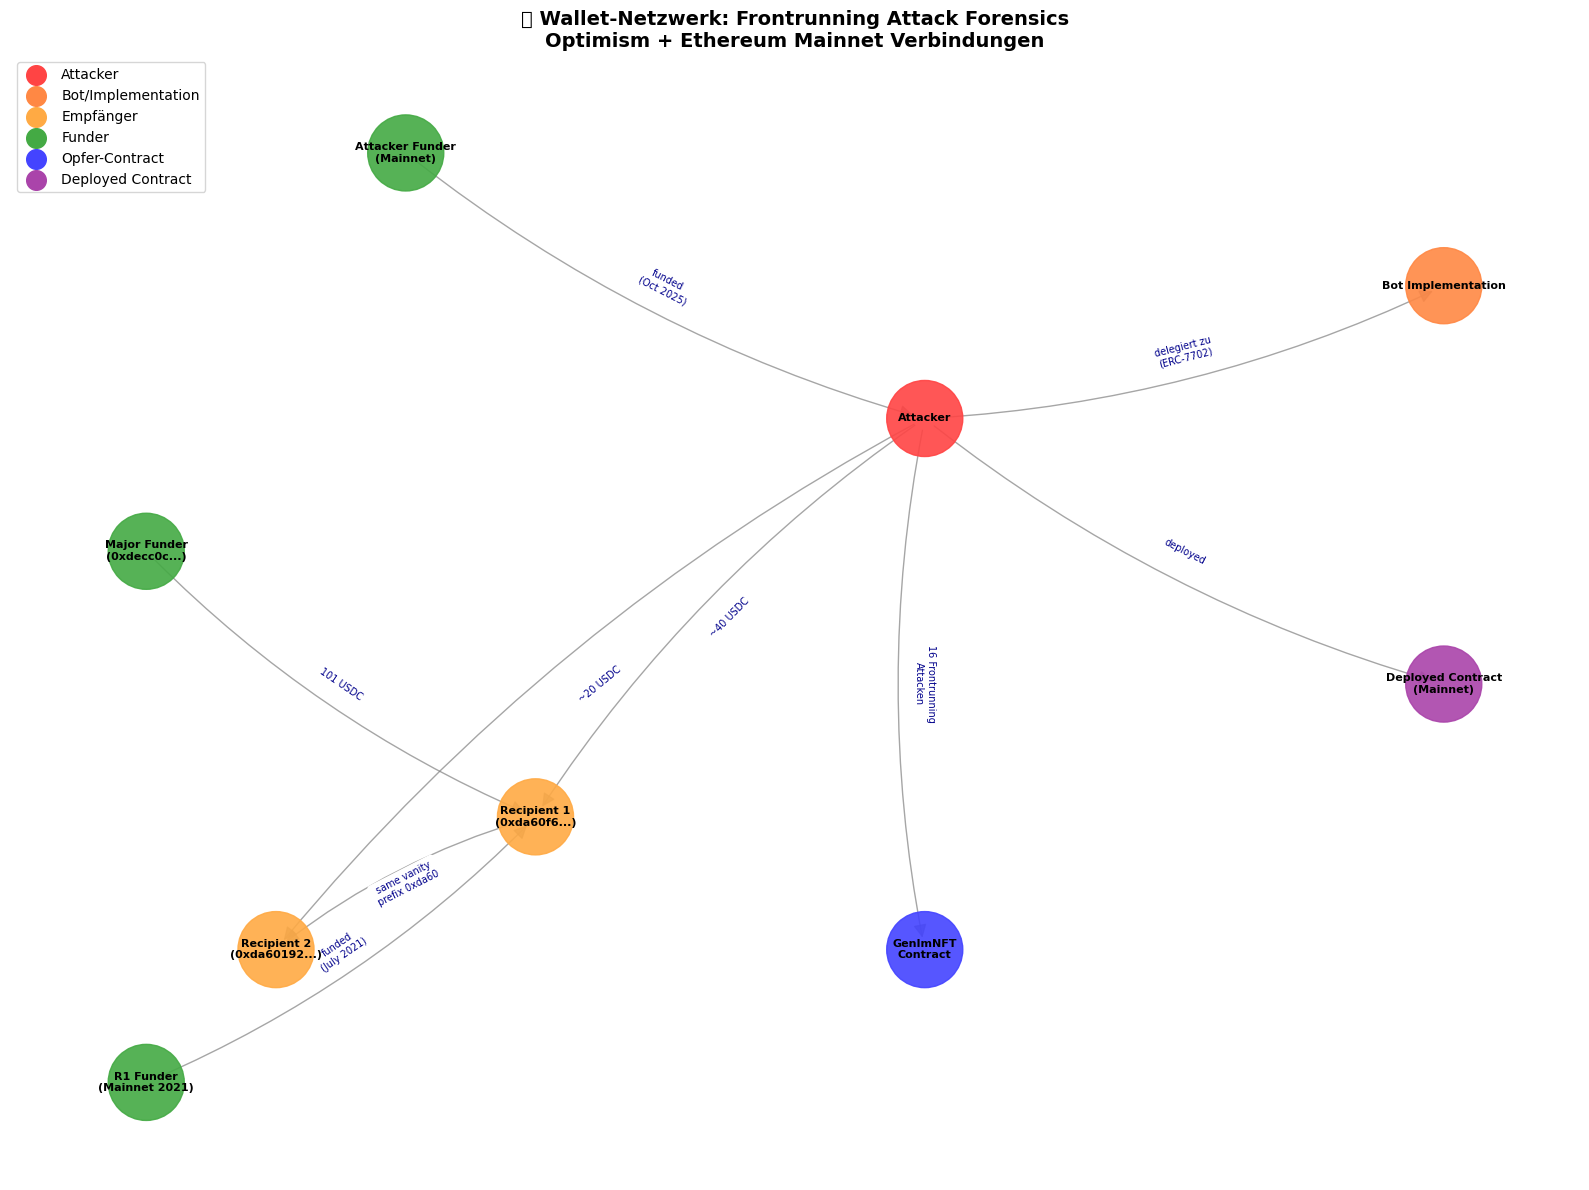


📊 NETZWERK-STATISTIKEN
   Knoten (Wallets/Contracts): 9
   Kanten (Verbindungen): 9

   Eingehende Verbindungen (In-Degree):
      Recipient 1 (0xda60f6...): 3
      Recipient 2 (0xda60192...): 2
      Attacker: 1
      Bot Implementation: 1
      GenImNFT Contract: 1
      Deployed Contract (Mainnet): 1

   Ausgehende Verbindungen (Out-Degree):
      Attacker: 5
      Recipient 1 (0xda60f6...): 1
      Major Funder (0xdecc0c...): 1
      Attacker Funder (Mainnet): 1
      R1 Funder (Mainnet 2021): 1


In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Erstelle gerichteten Graphen für Wallet-Netzwerk
G = nx.DiGraph()

# Definiere alle bekannten Adressen mit Labels
addresses = {
    "Attacker": "0x8B6B008A0073D34D04ff00210E7200Ab00003300",
    "Bot Implementation": "0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820",
    "Recipient 1\n(0xda60f6...)": "0xda60f6f99cea7fb4acfb3dfcb817691eaa41ba4e",
    "Recipient 2\n(0xda60192...)": "0xda60192af08b0564fd0f0aab19072a9d4149ba4e",
    "Major Funder\n(0xdecc0c...)": "0xdecc0c09c3b5f6e92ef7de1b2ce3e3df12fa05ac",
    "Attacker Funder\n(Mainnet)": "0x5babe600b9fcd5fb7b...",
    "R1 Funder\n(Mainnet 2021)": "0xddfabcdc4d8ffc6d5b...",
    "GenImNFT\nContract": "0x80f95d330417a4acEfEA415FE9eE28db7A0A1Cdb",
    "Deployed Contract\n(Mainnet)": "0x38d249e34d6bdc9e14e94e1c2bd95e46da6a6e16",
}

# Füge Knoten hinzu mit Kategorien
node_categories = {
    "Attacker": "attacker",
    "Bot Implementation": "bot",
    "Recipient 1\n(0xda60f6...)": "recipient",
    "Recipient 2\n(0xda60192...)": "recipient",
    "Major Funder\n(0xdecc0c...)": "funder",
    "Attacker Funder\n(Mainnet)": "funder",
    "R1 Funder\n(Mainnet 2021)": "funder",
    "GenImNFT\nContract": "victim",
    "Deployed Contract\n(Mainnet)": "deployed",
}

for label in addresses:
    G.add_node(label, category=node_categories[label])

# Definiere Kanten (Verbindungen) mit Beschreibungen
edges = [
    # Delegation
    ("Attacker", "Bot Implementation", "delegiert zu\n(ERC-7702)"),
    
    # Angriff
    ("Attacker", "GenImNFT\nContract", "16 Frontrunning\nAttacken"),
    
    # Geldflüsse auf Optimism
    ("Attacker", "Recipient 1\n(0xda60f6...)", "~40 USDC"),
    ("Attacker", "Recipient 2\n(0xda60192...)", "~20 USDC"),
    ("Major Funder\n(0xdecc0c...)", "Recipient 1\n(0xda60f6...)", "101 USDC"),
    
    # Mainnet Verbindungen
    ("Attacker Funder\n(Mainnet)", "Attacker", "funded\n(Oct 2025)"),
    ("Attacker", "Deployed Contract\n(Mainnet)", "deployed"),
    ("R1 Funder\n(Mainnet 2021)", "Recipient 1\n(0xda60f6...)", "funded\n(July 2021)"),
    
    # Vanity Address Verbindung
    ("Recipient 1\n(0xda60f6...)", "Recipient 2\n(0xda60192...)", "same vanity\nprefix 0xda60"),
]

for src, dst, label in edges:
    G.add_edge(src, dst, label=label)

# Visualisierung
fig, ax = plt.subplots(figsize=(16, 12))

# Layout - hierarchisch
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Manuelle Positionsanpassungen für bessere Übersicht
pos_manual = {
    "Attacker Funder\n(Mainnet)": (-2, 2),
    "Attacker": (0, 1),
    "Bot Implementation": (2, 1.5),
    "GenImNFT\nContract": (0, -1),
    "Recipient 1\n(0xda60f6...)": (-1.5, -0.5),
    "Recipient 2\n(0xda60192...)": (-2.5, -1),
    "Major Funder\n(0xdecc0c...)": (-3, 0.5),
    "R1 Funder\n(Mainnet 2021)": (-3, -1.5),
    "Deployed Contract\n(Mainnet)": (2, 0),
}

# Farben basierend auf Kategorie
color_map = {
    "attacker": "#FF4444",      # Rot - Angreifer
    "bot": "#FF8844",           # Orange - Bot
    "recipient": "#FFAA44",     # Gelb-Orange - Empfänger
    "funder": "#44AA44",        # Grün - Funder
    "victim": "#4444FF",        # Blau - Opfer
    "deployed": "#AA44AA",      # Lila - Deployed
}

node_colors = [color_map[node_categories[node]] for node in G.nodes()]

# Zeichne Knoten
nx.draw_networkx_nodes(G, pos_manual, node_color=node_colors, 
                       node_size=3000, alpha=0.9, ax=ax)

# Zeichne Kanten mit Pfeilen
nx.draw_networkx_edges(G, pos_manual, edge_color='gray', 
                       arrows=True, arrowsize=20, 
                       connectionstyle="arc3,rad=0.1",
                       alpha=0.7, ax=ax)

# Zeichne Labels
nx.draw_networkx_labels(G, pos_manual, font_size=8, font_weight='bold', ax=ax)

# Zeichne Kantenbeschriftungen
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos_manual, edge_labels, 
                             font_size=7, font_color='darkblue', ax=ax)

# Legende
legend_elements = [
    plt.scatter([], [], c='#FF4444', s=200, label='Attacker'),
    plt.scatter([], [], c='#FF8844', s=200, label='Bot/Implementation'),
    plt.scatter([], [], c='#FFAA44', s=200, label='Empfänger'),
    plt.scatter([], [], c='#44AA44', s=200, label='Funder'),
    plt.scatter([], [], c='#4444FF', s=200, label='Opfer-Contract'),
    plt.scatter([], [], c='#AA44AA', s=200, label='Deployed Contract'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.set_title("🕸️ Wallet-Netzwerk: Frontrunning Attack Forensics\n" + 
             "Optimism + Ethereum Mainnet Verbindungen", fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

# Netzwerk-Statistiken
print("\n" + "="*70)
print("📊 NETZWERK-STATISTIKEN")
print("="*70)
print(f"   Knoten (Wallets/Contracts): {G.number_of_nodes()}")
print(f"   Kanten (Verbindungen): {G.number_of_edges()}")
print(f"\n   Eingehende Verbindungen (In-Degree):")
for node, degree in sorted(G.in_degree(), key=lambda x: x[1], reverse=True):
    if degree > 0:
        print(f"      {node.replace(chr(10), ' ')}: {degree}")
print(f"\n   Ausgehende Verbindungen (Out-Degree):")
for node, degree in sorted(G.out_degree(), key=lambda x: x[1], reverse=True):
    if degree > 0:
        print(f"      {node.replace(chr(10), ' ')}: {degree}")